Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# Load medical images

This notebook describes how to easily load different formats of medical images in MONAI and execute additional image transforms.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/modules/load_medical_images.ipynb)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[itk, pillow, nibabel]"
!pip install -q "SimpleITK"

## Setup imports

In [ ]:
import os
import shutil
import SimpleITK as sitk  # noqa: N813
import numpy as np
import itk
import tempfile
import monai
from monai.data import PILReader
from monai.transforms import LoadImage, LoadImaged, Resized, Compose, SaveImage
from monai.config import print_config

print_config()

## Load Nifti image with default image reader
MONAI automatically choose readers based on the supported suffixes and in below order:
- User specified reader at runtime when call this loader.
- Registered readers from the latest to the first in list.
- Default readers: (nii, nii.gz -> NibabelReader), (png, jpg, bmp -> PILReader),
  (npz, npy -> NumpyReader), (others -> ITKReader).

### Download an example image

In [ ]:
# download a test image
tempdir = tempfile.mkdtemp()
test_url = "https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/avg152T1_RL_nifti.nii.gz"
filename = os.path.join(tempdir, "avg152T1_RL_nifti.nii.gz")
monai.apps.download_url(test_url, filepath=filename)

### Load the image file

In [4]:
data = LoadImage(image_only=True, ensure_channel_first=True, simple_keys=True)(filename)
print(f"image data shape: {data.shape}")
print(f"meta data: {data.meta.keys()}")

image data shape: torch.Size([1, 91, 109, 91])
meta data: dict_keys(['sizeof_hdr', 'extents', 'session_error', 'dim_info', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'qform_code', 'sform_code', affine, original_affine, 'as_closest_canonical', spatial_shape, space, original_channel_dim, 'filename_or_obj'])


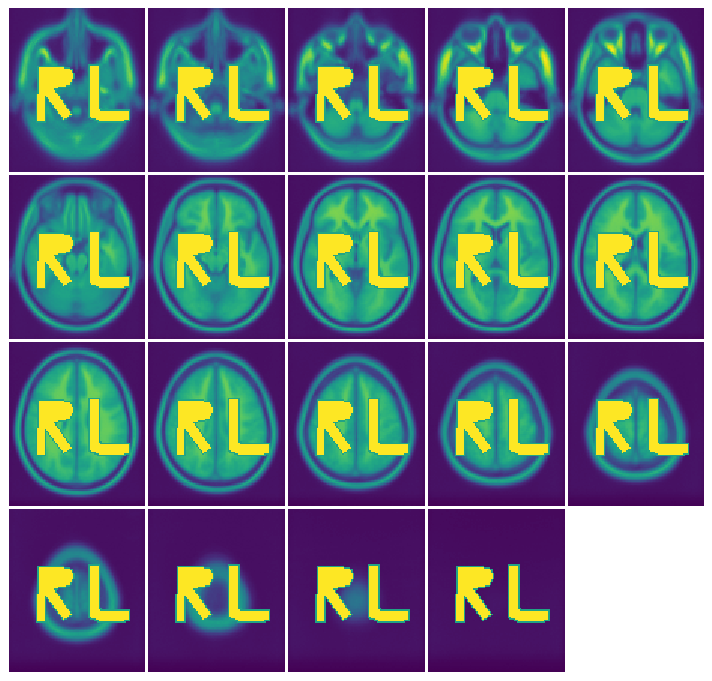

In [5]:
fig = monai.visualize.matshow3d(monai.transforms.Orientation("SPL")(data), every_n=5)

### Additional reader parameters

`LoadImage` supports additional parameters to the readers, the following commands show more examples.

Please see also https://docs.monai.io/en/stable/data.html#image-reader

In [6]:
img = LoadImage(image_only=True, reader="ITKReader", channel_dim=None, affine_lps_to_ras=False)(filename)
img = LoadImage(image_only=True, reader="NibabelReader", squeeze_non_spatial_dims=True)(filename)

## Load a list of Nifti images and stack them as a multi-channel image
Loading a list of files, stack them together and add a new dimension as first dimension.

And use the meta data of the first image to represent the stacked result.

### Generate some image examples

In [7]:
filenames = ["test_image.nii.gz", "test_image2.nii.gz", "test_image3.nii.gz"]
for i, name in enumerate(filenames):
    filenames[i] = os.path.join(tempdir, name)
    itk_np_view = itk.image_view_from_array(img.data)  # using the previous array as an example
    itk.imwrite(itk_np_view, filenames[i])
    print(f"written {name}")

written test_image.nii.gz
written test_image2.nii.gz
written test_image3.nii.gz


### Load the images
Note that the output data shape is (3, 96, 128, 64), indicating a three-channel image.

In [8]:
data, meta = LoadImage(image_only=False)(filenames)

print(f"image data shape: {data.shape}")
print(f"{type(data)}")

image data shape: torch.Size([3, 91, 109, 91])
<class 'monai.data.meta_tensor.MetaTensor'>


## Load 3D image in DICOM format

### Generate example images in different types

In [9]:
def get_dcm_image():
    """
    single image example
    """
    filename = os.path.join(tempdir, "test_image.dcm")
    dcm_image = np.random.randint(256, size=(64, 128, 96)).astype(np.uint8)
    itk_np_view = itk.image_view_from_array(dcm_image)
    itk.imwrite(itk_np_view, filename)
    return filename


def get_dcm_images():
    """
    multiple images as a multi-channel image
    """
    filenames = ["test_image-1.dcm", "test_image-2.dcm", "test_image-3.dcm"]
    for i, name in enumerate(filenames):
        filenames[i] = os.path.join(tempdir, name)
        dcm_image = np.random.randint(256, size=(64, 128, 96)).astype(np.uint8)
        itk_np_view = itk.image_view_from_array(dcm_image)
        itk.imwrite(itk_np_view, filenames[i])
    return filenames


def get_dcm_folder():
    """
    we need to generate DICOM series. To simplify this step, we will use SimpleITK.
    The following demo takes an official example of SimpleITK for reference.

    https://simpleitk.readthedocs.io/en/master/link_DicomSeriesFromArray_docs.html
    """
    sub_folder_path = os.path.join(tempdir, "test_DICOM")
    if not os.path.exists(sub_folder_path):
        os.mkdir(sub_folder_path)

    dcm_image = np.random.randint(256, size=(8, 16, 16)).astype(np.uint8)
    sitk_image = sitk.GetImageFromArray(dcm_image)

    writer = sitk.ImageFileWriter()
    writer.KeepOriginalImageUIDOn()

    for i in range(sitk_image.GetDepth()):
        image_slice = sitk_image[:, :, i]
        image_slice.SetMetaData("0020|000e", "1.2.3.")
        writer.SetFileName(os.path.join(sub_folder_path, str(i) + ".dcm"))
        writer.Execute(image_slice)
    return sub_folder_path

### Load the images

`LoadImage` supports images in DICOM as well as DICOM folders

In [10]:
for fn in (get_dcm_image(), get_dcm_images(), get_dcm_folder()):
    data = LoadImage(image_only=True)(fn)
    print(f"image data shape: {data.shape}")

image data shape: torch.Size([96, 128, 64])
image data shape: torch.Size([3, 96, 128, 64])
image data shape: torch.Size([16, 16, 8])


# Load 2D image in PNG format

### Download an image

In [ ]:
filename = os.path.join(tempdir, "MONAI-logo_color.png")
monai.apps.download_url("https://monai.io/assets/img/MONAI-logo_color.png", filepath=filename)

### Load the image

- Set `reverse_indexing=False` to ensure the spatial axes follow the 2D natual image convention used by Pillow/scikit-image.

- Set `reverse_indexing=True` (default) to be consistent with the other medical image readers.

In [12]:
data, meta = LoadImage(image_only=False, reader="PILReader", reverse_indexing=False)(filename)

print(f"image data shape: {data.shape}")
print(f"meta data: {meta}")

image data shape: torch.Size([31, 100, 4])
meta data: {'format': 'PNG', 'mode': 'RGBA', 'width': 100, 'height': 31, spatial_shape: array([100,  31]), original_channel_dim: -1, 'filename_or_obj': '/var/folders/6f/fdkl7m0x7sz3nj_t7p3ccgz00000gp/T/tmp9aoivd74/MONAI-logo_color.png', affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)}


## Load image with specified image reader

image data shape: torch.Size([4, 31, 100])
<class 'monai.data.meta_tensor.MetaTensor'>


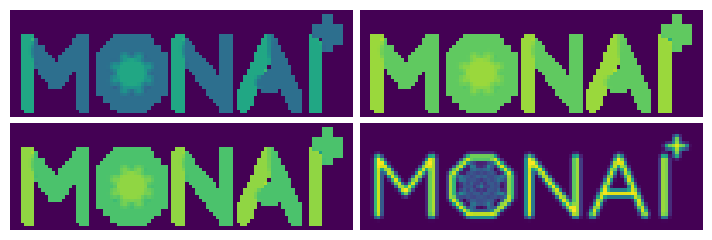

In [13]:
loader = LoadImage(image_only=False, ensure_channel_first=True)
loader.register(PILReader(reverse_indexing=False))
data, meta = loader(filename)

print(f"image data shape: {data.shape}")
print(f"{type(data)}")
fig = monai.visualize.matshow3d(data)

## Load image and execute additional operations
Some image readers can support additional operations after reading the image from file.

For example, we can set a converter for PILReader: `PILReader(converter=lambda image: image.convert("LA"))`.

In [14]:
loader = LoadImage(PILReader(converter=lambda image: image.convert("LA")), image_only=False)
data, meta = loader(filename)

print(f"image data shape: {data.shape}")
print(f"meta data: {meta}")

image data shape: torch.Size([100, 31, 2])
meta data: {'format': 'none', 'mode': 'LA', 'width': 100, 'height': 31, spatial_shape: array([100,  31]), original_channel_dim: -1, 'filename_or_obj': '/var/folders/6f/fdkl7m0x7sz3nj_t7p3ccgz00000gp/T/tmp9aoivd74/MONAI-logo_color.png', affine: tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], dtype=torch.float64)}


## Combine `LoadImage` with other transforms
It's very easy to connect `LoadImage` transform with other transforms to construct a transform chain.

In [15]:
transform = Compose(
    [
        LoadImaged(keys="image", image_only=True, ensure_channel_first=True, dtype=np.uint8),
        Resized(keys="image", spatial_size=[60, 64]),
    ]
)
test_data = {"image": filename}
result = transform(test_data)
print(f"image data shape:{result['image'].shape}")
print(result["image"].affine)

image data shape:torch.Size([4, 60, 64])
tensor([[ 1.6667,  0.0000,  0.0000,  0.3333],
        [ 0.0000,  0.4844,  0.0000, -0.2578],
        [ 0.0000,  0.0000,  1.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  1.0000]], dtype=torch.float64)


## Save image using `SaveImage` with different backends

In [16]:
img = result["image"]
# using the ITK backend
saver = SaveImage(
    output_dir=tempdir,
    output_ext=".png",
    output_postfix="itk",
    output_dtype=np.uint8,
    resample=False,
    writer="ITKWriter",
)
saver.set_options(data_kwargs={"spatial_ndim": 2})
img = saver(img)

# using the Nibabel backend
saver = SaveImage(
    output_dir=tempdir,
    output_ext=".nii.gz",
    output_dtype=np.uint8,
    resample=False,
    squeeze_end_dims=True,
    writer="NibabelWriter",
)
img = saver(img)

# using the PIL backend
saver = SaveImage(
    output_dir=tempdir,
    output_ext=".png",
    output_postfix="PIL",
    output_dtype=np.uint8,
    resample=False,
    squeeze_end_dims=True,
    writer="PILWriter",
)
img = saver(img)

2023-02-16 13:32:05,206 INFO image_writer.py:197 - writing: /var/folders/6f/fdkl7m0x7sz3nj_t7p3ccgz00000gp/T/tmp9aoivd74/MONAI-logo_color/MONAI-logo_color_itk.png
2023-02-16 13:32:05,212 INFO image_writer.py:197 - writing: /var/folders/6f/fdkl7m0x7sz3nj_t7p3ccgz00000gp/T/tmp9aoivd74/MONAI-logo_color/MONAI-logo_color_trans.nii.gz
2023-02-16 13:32:05,217 INFO image_writer.py:197 - writing: /var/folders/6f/fdkl7m0x7sz3nj_t7p3ccgz00000gp/T/tmp9aoivd74/MONAI-logo_color/MONAI-logo_color_PIL.png


## Cleanup data directory

Remove directory if a temporary was used.

In [17]:
shutil.rmtree(tempdir)